Updated October 26. Designs probes against the introns of a single gene. Blasts against transcriptome with introns, transcriptome without introns, and intergenic databases to verify specificity. 
Author: Giacomo Glotzer. 

In [440]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 

# Specify blast databases
new_transcriptome_db_no_introns = "../raw-data/OBir/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "../raw-data/OBir/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = '../raw-data/OBir/intergenics/all_intergenic_regions'
all_lncRNAs_db = '../raw-data/OBir/lncRNAs/all_ORs_antisense'

# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 

In [441]:
# Get a list of ORs with large introns 
for i, row in or_db.iterrows():
    gene = tr.get_gene(row["gene_name"])
    if len(gene.transcripts) == 0: 
        continue 
    or_db.at[i, 'intron_length'] = len(''.join([intron.sequence for intron in gene.get_transcript_longest_cds().introns])) 
    or_db.at[i, 'ta_size'] = or_db.loc[or_db['tandem_array'] == row['tandem_array'],:].shape[0]
    or_db.at[i, 'num_transcripts'] = len(gene.transcripts)

In [442]:
exon_probe_nums = pd.read_csv('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/all-ORs-probe-design/results/ORs-num-probes-excl-introns-20241223.csv')
exon_probe_nums.columns = ['gene_name', 'num_exon_probes']
exon_probe_nums['num_exon_probes'] = exon_probe_nums['num_exon_probes'].astype(int)
or_db = or_db.merge(exon_probe_nums, on='gene_name', how='left')
or_db

,chromosome,gene_name,tandem_array,rank,orientation,intron_length,ta_size,num_transcripts,num_exon_probes
0,1,Or5-R2,70,1,3',4565.0,2.0,1.0,7
1,1,Or5-Q1,70,2,5',1851.0,2.0,1.0,1
2,1,Or5-Orco,72,3,NaN,4423.0,2.0,1.0,67
3,1,Or5-Q2,72,4,NaN,2603.0,2.0,2.0,20
4,1,Or5-9E1,73,5,NaN,834.0,1.0,7.0,2
...,...,...,...,...,...,...,...,...,...
497,12,Or5-L35,3,498,3',1165.0,32.0,1.0,26
498,12,Or5-9E350,5,499,NaN,2067.0,1.0,2.0,2
499,12,Or5-9E351,6,500,NaN,9010.0,1.0,3.0,13
500,12,Or5-9Efrag3,7,501,NaN,826.0,1.0,1.0,0


In [443]:
or_db.loc[(or_db['ta_size'] > 3) & (or_db['num_exon_probes'] > 20) & (or_db['num_transcripts'] == 1), :].sort_values(by='intron_length', ascending=False).head(30)

,chromosome,gene_name,tandem_array,rank,orientation,intron_length,ta_size,num_transcripts,num_exon_probes
340,9,Or5-E7,86,341,NaN,3831.0,16.0,1.0,22
236,6,Or5-9E196,35,237,NaN,3735.0,13.0,1.0,24
60,2,Or5-9E38,62,61,NaN,3285.0,21.0,1.0,35
162,4,Or5-9E118,45,163,NaN,3226.0,22.0,1.0,21
136,3,Or5-V15,54,137,NaN,3183.0,24.0,1.0,37
253,6,Or5-9E214,37,254,NaN,2693.0,18.0,1.0,30
445,10,Or5-9E338,17,446,NaN,2460.0,82.0,1.0,22
129,3,Or5-V7,54,130,NaN,2435.0,24.0,1.0,26
308,7,Or5-U43,19,309,NaN,2377.0,55.0,1.0,26
349,9,Or5-E16,86,350,NaN,2344.0,16.0,1.0,23


In [467]:
or_db.loc[(or_db['tandem_array'] == 45) & (or_db['num_exon_probes'] > 15) & (or_db['num_transcripts'] > 0), :]

,chromosome,gene_name,tandem_array,rank,orientation,intron_length,ta_size,num_transcripts,num_exon_probes
158,4,Or5-9E114,45,159,NaN,4374.0,22.0,7.0,37
162,4,Or5-9E118,45,163,NaN,3226.0,22.0,1.0,21
165,4,Or5-9E121,45,166,NaN,3958.0,22.0,1.0,16
172,4,Or5-9E129,45,173,5',7727.0,22.0,3.0,27


In [444]:
# set main directory for writing files 
main_directory = '../raw-data/OBir/single_gene_intron_probe_design/'
if not os.path.exists(main_directory):
    os.makedirs(main_directory)

In [445]:
# Specify Gene 
gene_name = "Or5-9E118"

In [446]:
# Get gene 
gene = tr.get_gene(gene_name)
gene

Gene(name=Or5-9E118, id=Or5-9E118, transcripts=1, chromosome=Chr4, strand=-)

In [447]:
# Get transcript 
transcript = gene.get_transcript_longest_cds()
transcript 

Transcript(name=XM_020032758.2, 1185bp CDS, Chr4:10597561-10604866, exons=10, introns=9, utrs=0)

In [448]:
# Get chromosome 
chromosome = gene.chromosome
chromosome

'Chr4'

In [449]:
# Here we use only the INTRONs 
introns = transcript.introns 
if transcript.strand == '-':
    introns = sorted(introns, key=lambda x: x.position[0], reverse=True)
else:
    introns = sorted(introns, key=lambda x: x.position[0])
sequence = ''.join([intron.sequence for intron in introns]) 
gene.target_sequence = sequence
print(f"Sequence length: {len(sequence)}")
sequence

Sequence length: 3226


'GTAAATATAATACAAAGAATGATAGGTAAATTTAGAATATGGTTTATAATAATAAGATACTTCTTTTATGTGTATAAAAATCTAATAAAGTAAATTTATTATATATTTTATATATATCTCAGGTACGTCAGTGTCCAGGTAGGATACCTATATCAAGATGATGTCAGAATTTGGTCAGAGAATGAACACAGATGATCATGTTAAAATGATAGATGGATGCCACACACAGGCAGATTGTATTTTAAATTGATAAAAAGATGTTTTATAGCCATCTGTTTTTATGTAACGTTAATAATTAATTATTATTATTTATTATTATCAGAAACGTTTAAATAATTATAATATATTCAAATTGTAAAAATATTTTGTTGGCAAATGTATTTGTGTCCCCTTATATTTTTTTCGACTATCAAGAAATTCTTTTTTTTACAGAAGTTTGGCATATTGTTAAAGTTGTAAGAGTGGATATAATATTATAAATAATATTATGTTATTCATAATATTATTAATATTATGTTATGGTTTAAATTATTTATAATATAAATGACATATAATATTTCTATTTATAATATAAATTATTGTTATGATATAAATGTTATAAAAATAAATTAAGCGTAAAAAAATAACTTATTGCAAAAGCTTGCTTTAGGATATATTTAGGATCATCTCAGGATATTCTGTGCTATTTGAATTAAGTTATAAGCAACGCTTTGTCACTCTAGATAAGTAGCAATGAAATCAAACCTTATTTTACAGTTCTAATTATTCACTCTTTATTAGTATCAAGTTTCTAAATTATTTCAAACTGTATAAAAATTTTAATTAATCTATATATATATATATATATATATAATATATATATATATATAAGCCAAATACCACTCACTCACTCACTCACTCACTGACTCATCAACGTGCAGCCCGAACCACTGCACCTATCGACTTGAAATTTTAAGGGTATATTCCTTCTATTACGTAGGTGCTCACTAAGGGTGGGTT

In [450]:
# Export each gene sequence to a fasta file 
output_dir = os.path.join(main_directory, 'or_seq_blast_input')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

with open(f"{output_dir}/{gene.name}.fasta", 'w') as f: 
    f.write(f">{gene.name}\n{gene.target_sequence}")

In [451]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_input')
output_dir = os.path.join(main_directory, 'or_seq_blast_output')

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# get gene sequence path 
input_path = f"{input_dir}/{gene.name}.fasta"
# no introns 
output_path = f"{output_dir}/{gene.name}_blasted_no_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# yes introns
output_path = f"{output_dir}/{gene.name}_blasted_yes_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# intergenic 
output_path = f"{output_dir}/{gene.name}_blasted_intergenics.csv"
command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)

CompletedProcess(args="blastn -task blastn -query ../raw-data/OBir/single_gene_intron_probe_design/or_seq_blast_input/Or5-9E118.fasta -db ../raw-data/OBir/intergenics/all_intergenic_regions -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out ../raw-data/OBir/single_gene_intron_probe_design/or_seq_blast_output/Or5-9E118_blasted_intergenics.csv -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4", returncode=0)

In [452]:
length_thresh = 50 

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_output')
output_dir = os.path.join(main_directory, 'or_seq_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# No introns
input_path = f"{input_dir}/{gene.name}_blasted_no_introns.csv"
blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_no_introns['source'] = 'no_introns'

# Yes introns
input_path = f"{input_dir}/{gene.name}_blasted_yes_introns.csv"
blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_yes_introns['source'] = 'yes_introns'

# Intergenics 
input_path = f"{input_dir}/{gene.name}_blasted_intergenics.csv"
blast_results_intergenics = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_intergenics['source'] = 'intergenics'

# Concatenate 
blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns, blast_results_intergenics], axis=0)

# remove rows where length < length_thresh 
blast_results = blast_results.loc[(blast_results['length'].values >= length_thresh), :].reset_index(drop=True)

# Add column for subject gene ID 
blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

# Add column for whether the query and subject gene are the same
blast_results['same_gene'] = gene_name == blast_results['subject_gene_id']

# Get off-targets: 
off_targets = blast_results.loc[((blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['same_gene'] == False)) | # hits other genes 
                                ((blast_results['same_gene'] == True) & # hits exons of the same gene 
                                    (blast_results['source'] == 'no_introns')), :]

# Annotate off-targets 
sequence = gene.target_sequence
for j, row in off_targets.iterrows():
    sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]
gene.unique_sequence = sequence 

# Print the number of non '-' bp 
print(f"Number of available bp: {len(sequence.replace('-', ''))}")

# Save the blast results to the gene object 
gene.blast_results = blast_results

# Save the sequence to new file 
with open(f"{output_dir}/{gene.name}-introns_unique.fasta", 'w') as f:
    f.write(f">{gene.name}\n")
    f.write(sequence)

print(f"Unique regions have been annotated and exported to {output_dir}")

Number of available bp: 2545
Unique regions have been annotated and exported to ../raw-data/OBir/single_gene_intron_probe_design/or_seq_unique_regions


In [453]:
gene.blast_results.head()

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,same_gene
0,Or5-9E118,ref|XR_895219.2|,XR_895219,97.222,72,2,0,2928,2999,17,88,1.840000e-25,120.0,no_introns,LOC105286334,False
1,Or5-9E118,ref|XM_011346962.3|,XM_011346962,93.220,59,4,0,2936,2994,440,498,2.040000e-10,70.4,no_introns,Or5-9E350,False
2,Or5-9E118,ref|XM_011346960.3|,XM_011346960,93.220,59,4,0,2936,2994,437,495,2.040000e-10,70.4,no_introns,Or5-9E350,False
3,Or5-9E118,ref|XM_011352853.3|,XM_011352853,92.727,55,4,0,2930,2984,278,332,5.200000e-08,62.4,no_introns,LOC105287293,False
4,Or5-9E118,ref|XM_011352852.3|,XM_011352852,92.727,55,4,0,2930,2984,278,332,5.200000e-08,62.4,no_introns,LOC105287293,False


In [454]:
off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,same_gene
0,Or5-9E118,ref|XR_895219.2|,XR_895219,97.222,72,2,0,2928,2999,17,88,1.840000e-25,120.0,no_introns,LOC105286334,False
1,Or5-9E118,ref|XM_011346962.3|,XM_011346962,93.220,59,4,0,2936,2994,440,498,2.040000e-10,70.4,no_introns,Or5-9E350,False
2,Or5-9E118,ref|XM_011346960.3|,XM_011346960,93.220,59,4,0,2936,2994,437,495,2.040000e-10,70.4,no_introns,Or5-9E350,False
3,Or5-9E118,ref|XM_011352853.3|,XM_011352853,92.727,55,4,0,2930,2984,278,332,5.200000e-08,62.4,no_introns,LOC105287293,False
4,Or5-9E118,ref|XM_011352852.3|,XM_011352852,92.727,55,4,0,2930,2984,278,332,5.200000e-08,62.4,no_introns,LOC105287293,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,Or5-9E118,T13-Or5-9E244-Or5-9E245-Chr10:1981311-1984352,T13-Or5-9E244-Or5-9E245-Chr10:1981311-1984352,92.000,50,4,0,2847,2896,796,845,4.100000e-07,52.4,intergenics,None,False
672,Or5-9E118,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,94.366,71,4,0,2929,2999,134,64,9.460000e-20,94.4,intergenics,None,False
673,Or5-9E118,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,96.610,59,2,0,2941,2999,560,618,9.460000e-20,94.4,intergenics,None,False
674,Or5-9E118,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,T11-Or5-9E346-Or5-9E347-Chr11:13615858-13621282,91.304,69,6,0,2832,2900,233,165,2.510000e-11,66.4,intergenics,None,False


In [455]:
# Determine how many probes fit on each gene 
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, "B1")

print(f"There is enough space for {len(probes)} probes on {gene.name}")

There is enough space for 21 probes on Or5-9E118


In [456]:
# Specify amplifier 
amplifier = "B2"

In [457]:
# Specify how many probes 
n_probes = 30

In [458]:
# Export excel sheet with probes and excel sheet with probe binding regions 

# Design probes
sequence = gene.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, amplifier)

# Randomly select n_probes_per_gene probes 
np.random.seed(0)
if len(probes) < n_probes:
    indices = range(len(probes))
else: 
    indices = np.random.choice(range(len(probes)), n_probes, replace=False)
probes = [probes[i] for i in indices]
regions = [regions[i] for i in indices]


# Save probes and regions to gene object
gene.probes = probes
gene.regions = regions

# Collapse probes 
probes_collapsed = [probe for sublist in probes for probe in sublist]

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-introns-{amplifier}-{transcript.name}-{today}.xlsx"
# Create dataframe
df = pd.DataFrame({'Sequence': probes_collapsed})
# Add pool name column 
df['Pool name'] = f'{gene_name}-{amplifier}-{transcript.name}'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(probes_collapsed)} probes have been exported to {output_path}")


# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{gene_name}-introns-{amplifier}-{transcript.name}-regions-{today}.xlsx"
# Make a vector of the gene names for each probe 
target_genes = [gene.name for _ in range(len(probes))]
df = pd.DataFrame({'Gene': [gene.name for _ in range(len(probes))], 
                   'Region': regions, 
                   'Probe 1': [probe[0] for probe in gene.probes], 
                   'Probe 2': [probe[1] for probe in gene.probes]})
df.to_excel(output_path, index=False)

42 probes have been exported to ../raw-data/OBir/single_gene_intron_probe_design/IDT_sheets/Or5-9E118-introns-B2-XM_020032758.2-2025-06-19.xlsx


In [459]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [460]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against intergenics 
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted against the transcriptome")

All regions have been blasted against the transcriptome


In [461]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'intergenics'
    all_blast_results.append(blast_results)

In [462]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        continue

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # Add column for whether the query and subject gene are the same
    blast_results['same_gene'] = gene_name == blast_results['subject_gene_id']

    # Verify no off-target hits 
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & 
                                    (blast_results['mismatches'].values <= mismatch_thresh) & 
                                    ((blast_results['same_gene'] == False) | # hits other genes 
                                      ((blast_results['same_gene'] == True) & # hits exons of the same gene 
                                        (blast_results['source'] == 'no_introns'))), :]

    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


In [463]:
all_off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,same_gene


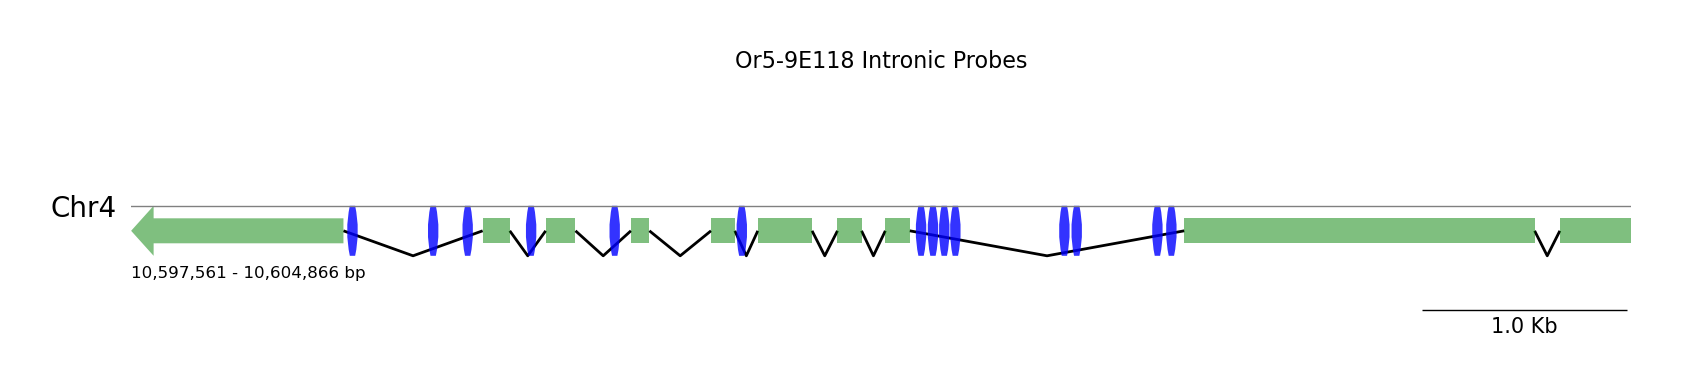

In [464]:
# Create a new GenomeViz object
gv = GenomeViz(track_align_type="center")
gv.set_scale_bar(ymargin=0.5)

# Get bounds 
chromosome = gene.chromosome
bounds = transcript.get_bounds() 
min_start = int(bounds[0])
max_end = int(bounds[1])
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add exons to plot
exon_bounds = [[int(exon.position[0]), int(exon.position[1])] for exon in transcript.exons]
exon_bounds = sorted(exon_bounds, key=lambda x: x[0])
strand = int(np.where(transcript.strand == '+', 1, -1) )
track.add_exon_feature(exon_bounds, strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, patch_kws=dict(fc="green", ec="none", alpha=0.5), intron_patch_kws=dict(ec="black", lw=2), label='')

# Add UTRs to the plot
for utr in transcript.utrs:
    track.add_feature(int(utr.position[0]), int(utr.position[1]), strand, plotstyle="box", lw=0, fc='grey', alpha=0.5)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="rbox", label = '', ec="none", fc="magenta", alpha=0.8)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="rbox", label = '', ec="none", fc="blue", alpha=0.8)

fig = gv.plotfig()

plt.title(f"{gene_name} Intronic Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/{gene_name}-{amplifier}-{transcript.name}-probes.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

